### Problem 5

#### Parameters  

In [1]:
max_steps_per_episode = 200
ENV_NAME = 'CartPole-v0'



import  os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

#### Import libraries  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#### Functions to make animation  

In [3]:
def display_frames_as_gif(frames):
    dpi = 200
    fig = plt.figure(figsize=(frames[0].shape[1]/dpi, frames[0].shape[0]/dpi),
                     dpi=dpi)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = FuncAnimation(plt.gcf(), animate, frames=len(frames),
                         interval=10, repeat=False)
    print('Saving images into an animation gif file ...')
    anim.save('movie_{}_random.gif'.format(ENV_NAME), writer='pillow')
    print('Done.')
    return anim

#### === Scripts to show movement with training ===  

#### Import libraries  

In [4]:
import rl.callbacks
import time

2022-01-20 23:42:56.561105: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-20 23:42:56.561145: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Class to get animation data during training (learning)  

In [5]:
class ViewLogger(rl.callbacks.Callback):
    def __init__(self):
        self.frames = []

    def on_action_end(self, action, logs):
        self.frames.append(self.env.render(mode='rgb_array'))

    def view(self, interval=5, start_frame=0, end_frame=0):
        assert start_frame<len(self.frames)
        self.start_frame = start_frame
        if end_frame == 0 or end_frame > len(self.frames):
            end_frame = len(self.frames)
        self.t0 = time.time()

        # display sizes
        plt.figure(figsize=(2.5,2.5), dpi=200)

        self.patch = plt.imshow(self.frames[0])
        plt.axis('off')

        anim = FuncAnimation(plt.gcf(), self._plot,
                             frames=end_frame-start_frame, interval=interval,
                             repeat=False)
        print('Saving images into an animation gif file ...')
        anim.save('movie_{}.gif'.format(ENV_NAME), writer='pillow')
        print('Done.')
        return anim.to_jshtml()

    def _plot(self, frame):
        if frame % max_steps_per_episode == 0:
            print("{}f {}m".format(frame, (time.time()-self.t0)/60))
        self.patch.set_data(self.frames[frame+self.start_frame])

#### Reinforcement learning using DQN  

#### Import libraries  

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory

#### Parameters  

In [7]:
env = gym.make(ENV_NAME)
nb_actions = env.action_space.n
nb_observ = env.observation_space.shape

In [19]:
np.random.seed(111)
env.seed(111)
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


#### (A) Build a very simple model for reinforcement learning  

In [9]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + nb_observ))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))

#### (B) Definition for the Agent by DQN  

In [10]:
memory = SequentialMemory(limit=50000, window_length=1)
policy = EpsGreedyQPolicy()
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

2022-01-20 23:43:00.226448: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-20 23:43:00.226508: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-20 23:43:00.226540: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (anhvu): /proc/driver/nvidia/version does not exist
2022-01-20 23:43:00.227544: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Execute training (learning)  

In [11]:
%%time

# If visualization is set to True, animation during the training can be seen.
# But this slows down training quite a lot
fit_log = dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)
#fit_log = dqn.fit(env, nb_steps=50000, visualize=True, verbose=1)

Training for 50000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 64s 6ms/step - reward: 1.0000
106 episodes - episode_reward: 92.670 [8.000, 200.000] - loss: 2.014 - mae: 17.521 - mean_q: 35.142

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: 1.0000
54 episodes - episode_reward: 187.667 [154.000, 200.000] - loss: 6.392 - mae: 38.645 - mean_q: 77.397

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 56s 6ms/step - reward: 1.0000
52 episodes - episode_reward: 189.731 [139.000, 200.000] - loss: 6.271 - mae: 43.703 - mean_q: 87.529

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 58s 6ms/step - reward: 1.0000
53 episodes - episode_reward: 191.094 [160.000, 200.000] - loss: 3.920 - mae: 39.431 - mean_q: 78.969

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: 1.0000
done,

#### Save the final weights  

In [12]:
weight_file = 'dqn_{}_weights.h5f'.format(ENV_NAME)
dqn.save_weights(weight_file, overwrite=True)

#### Show the history of rewards during the training  

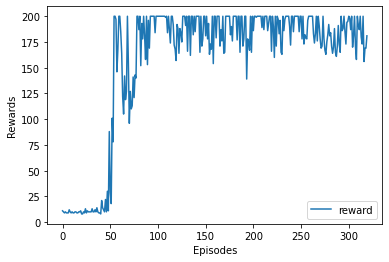

In [13]:
plt.plot(fit_log.history['episode_reward'], label='reward')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.show()

#### Finally, evaluate the model  

In [14]:
%%time

n_trials = 5
view = ViewLogger()
test_log = dqn.test(env, nb_episodes=n_trials, visualize=False, callbacks=[view])

Testing for 5 episodes ...
Episode 1: reward: 188.000, steps: 188
Episode 2: reward: 196.000, steps: 196
Episode 3: reward: 200.000, steps: 200
Episode 4: reward: 200.000, steps: 200
Episode 5: reward: 182.000, steps: 182
CPU times: user 2.63 s, sys: 852 ms, total: 3.48 s
Wall time: 16.6 s


In [15]:
env.close()